<a href="https://colab.research.google.com/github/saivarshitnune/Diabetic-retinory-image-classification/blob/Varshith/Diabetic_retinoapthy_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import matplotlib.pyplot as plt

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy

diagnosis-of-diabetic-retinopathy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diagnosis-of-diabetic-retinopathy.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths to data directories
# train_dir = "eye_data/train"
# test_dir = "eye_data/test"
# val_dir = "eye_data/valid"

train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/valid"

In [ ]:
# Define image size
img_width, img_height = 224, 224

In [ ]:
# Create image data generators
train_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )
val_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )

In [ ]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.


Application of ResNet 50 Architecture

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
base_model=keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=2,
    classifier_activation="binary",)


In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add two fully-connected layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x= Dense(64,activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
# Create the model
model2 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model2.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001) ,metrics=['Accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
ckpt_filename= "/content/drive/MyDrive/weightFiles"
checkpoint = ModelCheckpoint(filepath=ckpt_filename+'/'+'model_epoch_{epoch:02d}.h5', save_best_only=True, save_freq='epoch',save_weights_only=True,verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)#
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose = 1)

In [ ]:
# # Train the model
history=model2.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32,
    callbacks=[checkpoint, lr_reduce, early_stop]
)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.7123 - Accuracy: 0.5338
Epoch 1: val_loss improved from inf to 0.63434, saving model to /content/drive/MyDrive/weightFiles/model_epoch_01.h5
64/64 [==============================] - 46s 663ms/step - loss: 0.7123 - Accuracy: 0.5338 - val_loss: 0.6343 - val_Accuracy: 0.6738 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.6542 - Accuracy: 0.5905
Epoch 2: val_loss improved from 0.63434 to 0.58764, saving model to /content/drive/MyDrive/weightFiles/model_epoch_02.h5
64/64 [==============================] - 35s 549ms/step - loss: 0.6542 - Accuracy: 0.5905 - val_loss: 0.5876 - val_Accuracy: 0.7852 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.5977 - Accuracy: 0.6756
Epoch 3: val_loss improved from 0.58764 to 0.56815, saving model to /content/drive/MyDrive/weightFiles/model_epoch_03.h5
64/64 [==============================] - 35s 547ms/step - 

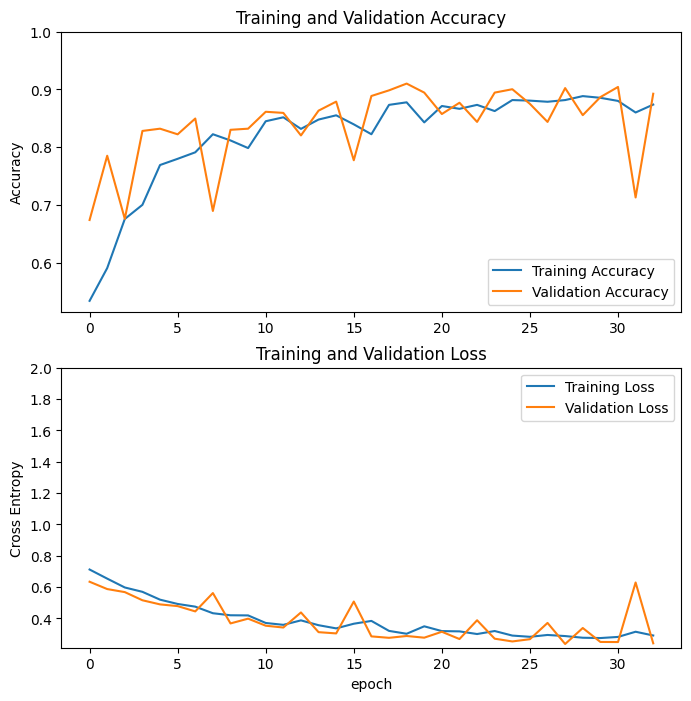

In [ ]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Predict on the test data
predictions = model2.predict(test_generator)

8/8 [==============================] - 2s 106ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)


# Calculate AUC
auc_score = auc(fpr, tpr)

# Find the threshold maximizing Youden's J statistic
max_j_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[max_j_idx]

print("AUC:", auc_score)
print("Optimal threshold:", optimal_thresh)

AUC: 0.9612269386530674
Optimal threshold: 0.38926372


In [ ]:
y_pred = (predictions >  0.38926372).astype("int32")


In [ ]:
# Generate classification report and confusion matrix
print("Classification report:")
print(classification_report(y_true, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       113
           1       0.92      0.90      0.91       118

    accuracy                           0.91       231
   macro avg       0.91      0.91      0.91       231
weighted avg       0.91      0.91      0.91       231



In [ ]:
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion matrix:
[[104   9]
 [ 12 106]]
